***preliminary operations***

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import inspect
from IPython.display import display, clear_output

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# checking that we are using a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Oct 17 14:46:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

We will also set the random seed, for reproducibility of results. 

In [4]:
# setting the seed for reproducibility
np.random.seed(1)
tf.random.set_seed(2)

install comsopower

In [5]:


import numpy as np
import tensorflow as tf
import pickle
from tqdm import trange
dtype = tf.float32


# =================================
#               NN
# =================================
class cosmopower_NN(tf.keras.Model):
    r"""
    Mapping between cosmological parameters and (log)-power spectra
    Attributes:
        parameters (list [str]):
            model parameters, sorted in the desired order
        modes (numpy.ndarray):
            multipoles or k-values in the (log)-spectra
        parameters_mean (numpy.ndarray):
            mean of input parameters
        parameters_std (numpy.ndarray):
            std of input parameters
        features_mean (numpy.ndarray):
            mean of output features
        features_std (numpy.ndarray):
            std of output features
        n_hidden (list [int]):
            number of nodes for each hidden layer
        restore (bool):
            whether to restore a previously trained model or not
        restore_filename (str):
            filename tag (without suffix) for restoring trained model from file 
            (this will be a pickle file with all of the model attributes and weights)
        trainable (bool):
            training layers
        optimizer (tf.keras.optimizers):
            optimizer for training
        verbose (bool):
            whether to print messages at intermediate steps or not
    """

    def __init__(self, 
                 parameters=None, 
                 modes=None, 
                 parameters_mean=None, 
                 parameters_std=None, 
                 features_mean=None, 
                 features_std=None, 
                 n_hidden=[512,512,512], 
                 restore=False, 
                 restore_filename=None, 
                 trainable=True,
                 optimizer=tf.keras.optimizers.Adam(),
                 verbose=False, 
                 ):
        """
        Constructor
        """
        # super
        super(cosmopower_NN, self).__init__()

        # restore
        if restore is True:
            self.restore(restore_filename)

        # else set variables from input arguments
        else:
            # attributes
            self.parameters = parameters
            self.n_parameters = len(self.parameters)
            self.modes = modes
            self.n_modes = len(self.modes)
            self.n_hidden = n_hidden

            # architecture
            self.architecture = [self.n_parameters] + self.n_hidden + [self.n_modes]
            self.n_layers = len(self.architecture) - 1

            # input parameters mean and std
            self.parameters_mean_ = parameters_mean if parameters_mean is not None else np.zeros(self.n_parameters)
            self.parameters_std_ = parameters_std if parameters_std is not None else np.ones(self.n_parameters)

            # (log)-spectra mean and std
            self.features_mean_ = features_mean if features_mean is not None else np.zeros(self.n_modes)
            self.features_std_ = features_std if features_std is not None else np.ones(self.n_modes)

        # input parameters mean and std
        self.parameters_mean = tf.constant(self.parameters_mean_, dtype=dtype, name='parameters_mean')
        self.parameters_std = tf.constant(self.parameters_std_, dtype=dtype, name='parameters_std')

        # (log)-spectra mean and std
        self.features_mean = tf.constant(self.features_mean_, dtype=dtype, name='features_mean')
        self.features_std = tf.constant(self.features_std_, dtype=dtype, name='features_std')

        # weights, biases and activation function parameters for each layer of the network
        self.W = []
        self.b = []
        self.alphas = []
        self.betas = [] 
        for i in range(self.n_layers):
            self.W.append(tf.Variable(tf.random.normal([self.architecture[i], self.architecture[i+1]], 0., 1e-3), name="W_" + str(i), trainable=trainable))
            self.b.append(tf.Variable(tf.zeros([self.architecture[i+1]]), name = "b_" + str(i), trainable=trainable))
        for i in range(self.n_layers-1):
            self.alphas.append(tf.Variable(tf.random.normal([self.architecture[i+1]]), name = "alphas_" + str(i), trainable=trainable))
            self.betas.append(tf.Variable(tf.random.normal([self.architecture[i+1]]), name = "betas_" + str(i), trainable=trainable))

        # restore weights if restore = True
        if restore is True:
            for i in range(self.n_layers):
              self.W[i].assign(self.W_[i])
              self.b[i].assign(self.b_[i])
            for i in range(self.n_layers-1):
              self.alphas[i].assign(self.alphas_[i])
              self.betas[i].assign(self.betas_[i])

        # optimizer
        self.optimizer = optimizer
        self.verbose= verbose

        # print initialization info, if verbose
        if self.verbose:
            multiline_str = "\nInitialized cosmopower_NN model, \n" \
                            f"mapping {self.n_parameters} input parameters to {self.n_modes} output modes, \n" \
                            f"using {len(self.n_hidden)} hidden layers, \n" \
                            f"with {list(self.n_hidden)} nodes, respectively. \n"
            print(multiline_str)


# ========== TENSORFLOW implementation ===============

    # non-linear activation function
    def activation(self, 
                   x, 
                   alpha, 
                   beta
                   ):
        r"""
        Non-linear activation function
        Parameters:
            x (Tensor):
                linear output from previous layer
            alpha (Tensor):
                trainable parameter
            beta (Tensor):
                trainable parameter
        Returns:
            Tensor:
                the result of applying the non-linear activation function to the linear output of the layer
        """
        return tf.multiply(tf.add(beta, tf.multiply(tf.sigmoid(tf.multiply(alpha, x)), tf.subtract(1.0, beta)) ), x)


    # tensor predictions
    @tf.function
    def predictions_tf(self, 
                       parameters_tensor
                       ):
        r"""
        Prediction given tensor of input parameters,
        fully implemented in TensorFlow
        Parameters:
            parameters_tensor (Tensor):
                input parameters
        Returns:
            Tensor:
                output predictions
        """
        outputs = []
        layers = [tf.divide(tf.subtract(parameters_tensor, self.parameters_mean), self.parameters_std)]
        for i in range(self.n_layers - 1):

            # linear network operation
            outputs.append(tf.add(tf.matmul(layers[-1], self.W[i]), self.b[i]))

            # non-linear activation function
            layers.append(self.activation(outputs[-1], self.alphas[i], self.betas[i]))

        # linear output layer
        layers.append(tf.add(tf.matmul(layers[-1], self.W[-1]), self.b[-1]))

        # rescale -> output predictions
        return tf.add(tf.multiply(layers[-1], self.features_std), self.features_mean)


    # tensor 10.**predictions
    @tf.function
    def ten_to_predictions_tf(self, 
                           parameters_tensor
                           ):
        r"""
        10^predictions given tensor of input parameters,
        fully implemented in TensorFlow. It raises 10 to the output
        of ``predictions_tf``
        Parameters:
            parameters_tensor (Tensor):
                input parameters
        Returns:
            Tensor:
                10^output predictions
        """
        return tf.pow(10., self.predictions_tf(parameters_tensor))


# ============= SAVE/LOAD model =============

    # save network parameters to Numpy arrays
    def update_emulator_parameters(self):
        r"""
        Update emulator parameters before saving them
        """
        # put network parameters to numpy arrays
        self.W_ = [self.W[i].numpy() for i in range(self.n_layers)]
        self.b_ = [self.b[i].numpy() for i in range(self.n_layers)]
        self.alphas_ = [self.alphas[i].numpy() for i in range(self.n_layers-1)]
        self.betas_ = [self.betas[i].numpy() for i in range(self.n_layers-1)]

        # put mean and std parameters to numpy arrays
        self.parameters_mean_ = self.parameters_mean.numpy()
        self.parameters_std_ = self.parameters_std.numpy()
        self.features_mean_ = self.features_mean.numpy()
        self.features_std_ = self.features_std.numpy()


    # save
    def save(self, 
             filename
             ):
        r"""
        Save network parameters
        Parameters:
            filename (str):
                filename tag (without suffix) where model will be saved
        """
        # attributes
        attributes = [self.W_, 
                      self.b_, 
                      self.alphas_, 
                      self.betas_, 
                      self.parameters_mean_, 
                      self.parameters_std_,
                      self.features_mean_,
                      self.features_std_,
                      self.n_parameters,
                      self.parameters,
                      self.n_modes,
                      self.modes,
                      self.n_hidden,
                      self.n_layers,
                      self.architecture]

        # save attributes to file
        with open(filename + ".pkl", 'wb') as f:
            pickle.dump(attributes, f)


    # restore attributes
    def restore(self, 
                filename
                ):
        r"""
        Load pre-trained model
        Parameters:
            filename (str):
                filename tag (without suffix) where model was saved
        """
        # load attributes
        with open(filename + ".pkl", 'rb') as f:
            self.W_, self.b_, self.alphas_, self.betas_, \
            self.parameters_mean_, self.parameters_std_, \
            self.features_mean_, self.features_std_, \
            self.n_parameters, self.parameters, \
            self.n_modes, self.modes, \
            self.n_hidden, self.n_layers, self.architecture = pickle.load(f)


# ========== NUMPY implementation ===============

    # auxiliary function to sort input parameters
    def dict_to_ordered_arr_np(self, 
                               input_dict, 
                               ):
        r"""
        Sort input parameters
        Parameters:
            input_dict (dict [numpy.ndarray]):
                input dict of (arrays of) parameters to be sorted
        Returns:
            numpy.ndarray:
                parameters sorted according to desired order
        """
        if self.parameters is not None:
            return np.stack([input_dict[k] for k in self.parameters], axis=1)
        else:
            return np.stack([input_dict[k] for k in input_dict], axis=1)


    # forward prediction given input parameters implemented in Numpy
    def forward_pass_np(self, 
                        parameters_arr
                        ):
        r"""
        Forward pass through the network to predict the output, 
        fully implemented in Numpy
        Parameters:
            parameters_arr (numpy.ndarray):
                array of input parameters
        Returns:
          numpy.ndarray:
            output predictions
        """
        # forward pass through the network
        act = []
        layers = [(parameters_arr - self.parameters_mean_)/self.parameters_std_]
        for i in range(self.n_layers-1):

            # linear network operation
            act.append(np.dot(layers[-1], self.W_[i]) + self.b_[i])

            # pass through activation function
            layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])

        # final (linear) layer -> (standardised) predictions
        layers.append(np.dot(layers[-1], self.W_[-1]) + self.b_[-1])

        # rescale and output
        return layers[-1]*self.features_std_ + self.features_mean_


    # Numpy array predictions
    def predictions_np(self, 
                       parameters_dict
                       ):
        r"""
        Predictions given input parameters collected in a dict.
        Fully implemented in Numpy. Calls ``forward_pass_np``
        after ordering the input parameter dict
        Parameters:
            parameters_dict (dict [numpy.ndarray]):
                dictionary of (arrays of) parameters
        Returns:
            numpy.ndarray:
                output predictions
        """
        parameters_arr = self.dict_to_ordered_arr_np(parameters_dict)
        return self.forward_pass_np(parameters_arr)


    # Numpy array 10.**predictions
    def ten_to_predictions_np(self,
                            parameters_dict
                            ):
        r"""
        10^predictions given input parameters collected in a dict.
        Fully implemented in Numpy. It raises 10 to the output
        from ``forward_pass_np``
        Parameters:
            parameters_dict (dict [numpy.ndarray]):
                dictionary of (arrays of) parameters
        Returns:
            numpy.ndarray:
                10^output predictions
        """
        return 10.**self.predictions_np(parameters_dict)



    ### Infrastructure for network training ###

    @tf.function
    def compute_loss(self,
                     training_parameters,
                     training_features
                     ):
        r"""
        Mean squared difference
        Parameters:
            training_parameters (Tensor):
                input parameters
            training_features (Tensor):
                true features
        Returns:
            Tensor:
                mean squared difference
        """
        return tf.sqrt(tf.reduce_mean(tf.math.squared_difference(self.predictions_tf(training_parameters), training_features)))


    @tf.function
    def compute_loss_and_gradients(self, 
                                   training_parameters,
                                   training_features
                                   ):
        r"""
        Computes mean squared difference and gradients
        Parameters:
            training_parameters (Tensor):
                input parameters
            training_features (Tensor):
                true features
        Returns:
            loss (Tensor):
                mean squared difference
            gradients (Tensor):
                gradients
        """
        # compute loss on the tape
        with tf.GradientTape() as tape:

            # loss
            loss = tf.sqrt(tf.reduce_mean(tf.math.squared_difference(self.predictions_tf(training_parameters), training_features))) 

        # compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        return loss, gradients


    def training_step(self, 
                      training_parameters,
                      training_features
                      ):
        r"""
        Minimize loss
        Parameters:
            training_parameters (Tensor):
                input parameters
            training_features (Tensor):
                true features
        Returns:
            loss (Tensor):
                mean squared difference
        """
        # compute loss and gradients
        loss, gradients = self.compute_loss_and_gradients(training_parameters, training_features)

        # apply gradients
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return loss


    def training_step_with_accumulated_gradients(self, 
                                                 training_parameters, 
                                                 training_features, 
                                                 accumulation_steps=10):
        r"""
        Minimize loss, breaking calculation into accumulated gradients
        Parameters:
            training_parameters (Tensor):
                input parameters
            training_features (Tensor):
                true features
            accumulation_steps (int):
                number of accumulated gradients
        Returns:
            accumulated_loss (Tensor):
                mean squared difference
        """
        # create dataset to do sub-calculations over
        dataset = tf.data.Dataset.from_tensor_slices((training_parameters, training_features)).batch(int(training_features.shape[0]/accumulation_steps))

        # initialize gradients and loss (to zero)
        accumulated_gradients = [tf.Variable(tf.zeros_like(variable), trainable=False) for variable in self.trainable_variables]
        accumulated_loss = tf.Variable(0., trainable=False)

        # loop over sub-batches
        for training_parameters_, training_features_, in dataset:

            # calculate loss and gradients
            loss, gradients = self.compute_loss_and_gradients(training_parameters_, training_features_)

            # update the accumulated gradients and loss
            for i in range(len(accumulated_gradients)):
                accumulated_gradients[i].assign_add(gradients[i]*training_features_.shape[0]/training_features.shape[0])
            accumulated_loss.assign_add(loss*training_features_.shape[0]/training_features.shape[0])

            # apply accumulated gradients
            self.optimizer.apply_gradients(zip(accumulated_gradients, self.trainable_variables))

        return accumulated_loss


# ==========================================
#         main TRAINING function
# ==========================================
    def train(self,
              training_parameters,
              training_features,
              filename_saved_model,
              # cooling schedule
              validation_split=0.1,
              learning_rates=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
              batch_sizes=[1024, 1024, 1024, 1024, 1024],
              gradient_accumulation_steps = [1, 1, 1, 1, 1],
              # early stopping set up
              patience_values = [100, 100, 100, 100, 100],
              max_epochs = [1000, 1000, 1000, 1000, 1000],
             ):
        r"""
        Train the model
        Parameters:
            training_parameters (dict [numpy.ndarray]):
                input parameters
            training_features (numpy.ndarray):
                true features for training
            filename_saved_model (str):
                filename tag where model will be saved
            validation_split (float):
                percentage of training data used for validation
            learning_rates (list [float]):
                learning rates for each step of learning schedule
            batch_sizes (list [int]):
                batch sizes for each step of learning schedule
            gradient_accumulation_steps (list [int]):
                batches for gradient accumulations for each step of learning schedule
            patience_values (list [int]):
                early stopping patience for each step of learning schedule
            max_epochs (list [int]):
                maximum number of epochs for each step of learning schedule
        """
        # check correct number of steps
        assert len(learning_rates)==len(batch_sizes)\
               ==len(gradient_accumulation_steps)==len(patience_values)==len(max_epochs), \
               'Number of learning rates, batch sizes, gradient accumulation steps, patience values and max epochs are not matching!'

        # training start info, if verbose
        if self.verbose:
            multiline_str = "Starting cosmopower_NN training, \n" \
                            f"using {int(100*validation_split)} per cent of training samples for validation. \n" \
                            f"Performing {len(learning_rates)} learning steps, with \n" \
                            f"{list(learning_rates)} learning rates \n" \
                            f"{list(batch_sizes)} batch sizes \n" \
                            f"{list(gradient_accumulation_steps)} gradient accumulation steps \n" \
                            f"{list(patience_values)} patience values \n" \
                            f"{list(max_epochs)} max epochs \n"
            print(multiline_str)

        # from dict to array
        training_parameters = self.dict_to_ordered_arr_np(training_parameters)

        # parameters standardisation
        self.parameters_mean = np.mean(training_parameters, axis=0)
        self.parameters_std = np.std(training_parameters, axis=0)

        # features standardisation
        self.features_mean = np.mean(training_features, axis=0)
        self.features_std = np.std(training_features, axis=0)

        # input parameters mean and std
        self.parameters_mean = tf.constant(self.parameters_mean, dtype=dtype, name='parameters_mean')
        self.parameters_std = tf.constant(self.parameters_std, dtype=dtype, name='parameters_std')

        # (log)-spectra mean and std
        self.features_mean = tf.constant(self.features_mean, dtype=dtype, name='features_mean')
        self.features_std = tf.constant(self.features_std, dtype=dtype, name='features_std')

        # training/validation split
        n_validation = int(training_parameters.shape[0] * validation_split)
        n_training = training_parameters.shape[0] - n_validation

        # casting
        training_parameters = tf.convert_to_tensor(training_parameters, dtype=dtype)
        training_features = tf.convert_to_tensor(training_features, dtype=dtype)

        full_training_loss = []
        full_validation_loss = []

        # train using cooling/heating schedule for lr/batch-size
        for i in range(len(learning_rates)):

            print('learning rate = ' + str(learning_rates[i]) + ', batch size = ' + str(batch_sizes[i]))

            # set learning rate
            self.optimizer.lr = learning_rates[i]

            # split into validation and training sub-sets
            training_selection = tf.random.shuffle([True] * n_training + [False] * n_validation)

            # create iterable dataset (given batch size)
            training_data = tf.data.Dataset.from_tensor_slices((training_parameters[training_selection], training_features[training_selection])).shuffle(n_training).batch(batch_sizes[i])

            # set up training loss
            training_loss = [np.infty]
            validation_loss = [np.infty]
            best_loss = np.infty
            early_stopping_counter = 0

            # loop over epochs
            with trange(max_epochs[i]) as t:
                for epoch in t:
                    # loop over batches
                    for theta, feats in training_data:

                        # training step: check whether to accumulate gradients or not (only worth doing this for very large batch sizes)
                        if gradient_accumulation_steps[i] == 1:
                            loss = self.training_step(theta, feats)
                            training_loss.append(loss)
                        else:
                            loss = self.training_step_with_accumulated_gradients(theta, feats, accumulation_steps=gradient_accumulation_steps[i])

                    # compute validation loss at the end of the epoch
                    validation_loss.append(self.compute_loss(training_parameters[~training_selection], training_features[~training_selection]).numpy())

                    # update the progressbar
                    t.set_postfix(loss=validation_loss[-1])

                    # early stopping condition
                    if validation_loss[-1] < best_loss:
                        best_loss = validation_loss[-1]
                        early_stopping_counter = 0
                    else:
                        early_stopping_counter += 1
                    if early_stopping_counter >= patience_values[i]:
                        self.update_emulator_parameters()
                        self.save(filename_saved_model)
                        print('Validation loss = ' + str(best_loss))
                        print('Model saved.')
                        break
                self.update_emulator_parameters()
                self.save(filename_saved_model)
                print('Reached max number of epochs. Validation loss = ' + str(best_loss))
                print('Model saved.')
                full_validation_loss.append(validation_loss)
                full_training_loss.append(training_loss)

        return full_training_loss , full_validation_loss 


don't forget to mount google drive! 

now load the data

In [6]:
data = pickle.load(open('/content/drive/MyDrive/21cm project/data for training/trainingData_28000samples_all_params_131022_z=7.9_.pk' , 'rb'))

training_params = {}
training_powerspectra = []
testing_params = {}
testing_powerspectra = []

for param in data[0]['model params'].keys():
  training_params[param] = np.array([])
  testing_params[param] = np.array([])
model_params = list(data[0]['model params'].keys())


In [7]:
#split the data here

for i , sample in enumerate(data.items()):
  if i < len(data.items())*0.9:
    if not np.array_equal([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],sample[1]['ps']):
      for param in sample[1]['model params'].items(): 
        training_params[param[0]] =  np.append(training_params[param[0]] , param[1])
      training_powerspectra +=[np.log10(sample[1]['ps'])]
  else:
    if not np.array_equal([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],sample[1]['ps']):
      for param in sample[1]['model params'].items():  
        testing_params[param[0]] =  np.append(testing_params[param[0]] , param[1])
      testing_powerspectra +=[sample[1]['ps']]
testing_features = np.array(testing_powerspectra)   
features = np.array(training_powerspectra)
k_range = data[0]['k']


#data normalization
# hyperparams = [[],[]]

# for i , data_set in enumerate(training_params.items()):
#   hyperparams[0]+= [np.mean(data_set[1])]
#   hyperparams[1] += [np.std(data_set[1])]
#   training_params[data_set[0]] = (data_set[1]-hyperparams[0][i])/hyperparams[1][i]
# #pickle.dump(hyperparams,open('model_hyperparams_z=7.9.pk' ,'wb'))  

# for item in testing_params.items():
#   print(item[1][5])
# for i,data_set in enumerate(testing_params.items()):  
#   testing_params[data_set[0]] = (data_set[1]-hyperparams[0][i])/hyperparams[1][i]




print('features shape:',features.shape)
print('k modes: ' , k_range)
print('num of samples '+ str(len(training_params['F_ESC10'])))
print('testing features shape:',testing_features.shape)


features shape: (22385, 11)
k modes:  [0.03005976 0.04508964 0.06763446 0.1014517  0.15217754 0.22826631
 0.34239947 0.51359921 0.77039881 1.15559822 1.73339733]
num of samples 22385
testing features shape: (2474, 11)


In [ ]:
print(training_params)


{'F_STAR10': array([-2.9423636 , -2.01685408, -2.72802349, ..., -1.29870081,
       -0.24941765, -2.83947246]), 'ALPHA_STAR': array([ 0.36711845, -0.2725655 ,  0.50046457, ..., -0.24593669,
        0.00367806, -0.06596622]), 'F_ESC10': array([-0.7023868 , -0.98614487, -2.68852475, ..., -1.35656514,
       -1.90424171, -1.36995852]), 'ALPHA_ESC': array([-0.77860689, -0.74791648, -0.63084874, ..., -0.83990472,
       -0.41781939, -0.82266651]), 'M_TURN': array([11.79283604, 11.8936088 , 11.52376068, ...,  9.3958622 ,
       11.17295513,  8.00650779]), 't_STAR': array([0.31569324, 0.4841325 , 0.32922138, ..., 0.60595247, 0.70275379,
       0.47078367]), 'L_X': array([30.48517858, 32.1022846 , 41.302221  , ..., 38.19321393,
       31.30727559, 37.67548518]), 'NU_X_THRESH': array([1190.57154298,  681.57781835,  487.3179135 , ...,  763.09077349,
        113.44159252, 1225.54575799]), 'X_RAY_SPEC_INDEX': array([ 0.69270425,  0.02416324,  1.77517546, ..., -0.08305445,
        1.46435894,  1.25

#todo - remove some features for testing and take the log powerspectra when ps!=0

**CLASS INSTANTIATION**

In [9]:


# instantiate NN class
cp_nn = cosmopower_NN(parameters=model_params, 
                      modes=k_range, 
                      n_hidden = [512, 512, 512, 512], # 4 hidden layers, each with 512 nodes
                      verbose=True, # useful to understand the different steps in initialisation and training
                      )


Initialized cosmopower_NN model, 
mapping 9 input parameters to 11 output modes, 
using 4 hidden layers, 
with [512, 512, 512, 512] nodes, respectively. 



In this section we will train our model. 

To do this, we will call the method `train()` from the `cosmopower_NN` class.
Here are the input arguments for this function:

* `training_parameters`: as explained above, this is a `dict` of `np.arrays` of input parameters. Each `dict` key has a `np.array` of values, for example

```python
training_parameters = {`omega_b` : np.array([0.0222, 0.0213, 0.0241, ...]),
                       `omega_cdm` : np.array([0.114, 0.134, 0.124, ...]),
                        ... etc ...
                      }
```
(each `np.array` has the same number of elements, equal to the number of training samples);

* `training_features`: a `np.array` of training (log)-power spectra. Its dimensions are (number of training samples, number of Fourier modes);

* `filename_saved_model`: path (without suffix) to the `.pkl` file where the trained model will be saved;

* `validation split`: `float` between 0 and 1, percentage of samples from the training set that will be used for validation.


Some of the input arguments allow for the implementation of a learning schedule with different steps, each characterised by a different learning rate. In addition to the learning rate, the user can change other hyperparameters, such as the batch size, at each learning step:

* `learning_rates`: `list` of `float` values, the optimizer learning rate at each learning step;

* `batch_sizes`: `list` of `float` values, batch size for each learning step;

* `gradient_accumulation_steps`: `list` of `int` values, the number of accumulation batches if using gradient accumulation, at each learning step. Set these numbers to > 1 to activate gradient accumulation - only worth doing if using very large batch sizes;

* `patience_values`: `list` of `int` values, the number of epochs to wait for early stopping, at each learning step;

* `max_epochs`: `list` of `int` values, the maximum number of epochs for each learning step.

In [10]:
with tf.device('/device:GPU:0'): # ensures we are running on a GPU
    # train
    training_loss, validation_loss= cp_nn.train(training_parameters=training_params,
                training_features=features,
                filename_saved_model='/content/drive/MyDrive/21cm project/models/21cm_PS_NN_z=7.9_131022_all_params_for_validation',
                # cooling schedule
                validation_split=0.1,
                learning_rates=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
                batch_sizes=[512, 512, 512, 512, 512],
                gradient_accumulation_steps = [1, 1, 1, 1, 1],
                # early stopping set up
                patience_values = [200,200,200,200,200],
                max_epochs = [2000,2000,2000,2000,2000],
                )

Starting cosmopower_NN training, 
using 10 per cent of training samples for validation. 
Performing 5 learning steps, with 
[0.01, 0.001, 0.0001, 1e-05, 1e-06] learning rates 
[512, 512, 512, 512, 512] batch sizes 
[1, 1, 1, 1, 1] gradient accumulation steps 
[200, 200, 200, 200, 200] patience values 
[2000, 2000, 2000, 2000, 2000] max epochs 

learning rate = 0.01, batch size = 512


 48%|████▊     | 970/2000 [05:50<06:12,  2.76it/s, loss=0.128]


Validation loss = 0.02447876
Model saved.
Reached max number of epochs. Validation loss = 0.02447876
Model saved.
learning rate = 0.001, batch size = 512


 17%|█▋        | 344/2000 [02:02<09:51,  2.80it/s, loss=0.0156]


Validation loss = 0.012834141
Model saved.
Reached max number of epochs. Validation loss = 0.012834141
Model saved.
learning rate = 0.0001, batch size = 512


 17%|█▋        | 334/2000 [01:58<09:52,  2.81it/s, loss=0.00345]


Validation loss = 0.0033816467
Model saved.
Reached max number of epochs. Validation loss = 0.0033816467
Model saved.
learning rate = 1e-05, batch size = 512


100%|██████████| 2000/2000 [11:42<00:00,  2.85it/s, loss=0.000413]


Reached max number of epochs. Validation loss = 0.0003920814
Model saved.
learning rate = 1e-06, batch size = 512


100%|██████████| 2000/2000 [11:30<00:00,  2.89it/s, loss=0.000219]

Reached max number of epochs. Validation loss = 0.00021870242
Model saved.


In [11]:
pickle.dump([validation_loss, training_loss], open('/content/drive/MyDrive/21cm project/models/validation.pk', 'wb'))


In [23]:
val01 = np.append(validation_loss[0],validation_loss[1])
tra01 = np.append(training_loss[0],training_loss[1])
print(val01)

[1.         0.72630578 0.64060849 ... 0.01489089 0.0148941  0.01561755]


In [14]:
validation_loss, training_loss = pickle.load(open('/content/drive/MyDrive/21cm project/models/validation.pk', 'rb'))

In [21]:
print(len(validation_loss[0]), len(training_loss[0]))

972 38841


In [22]:

training_loss[0] = np.clip(training_loss[0], 0 , 1)
validation_loss[0] = np.clip(validation_loss[0], 0 ,1)

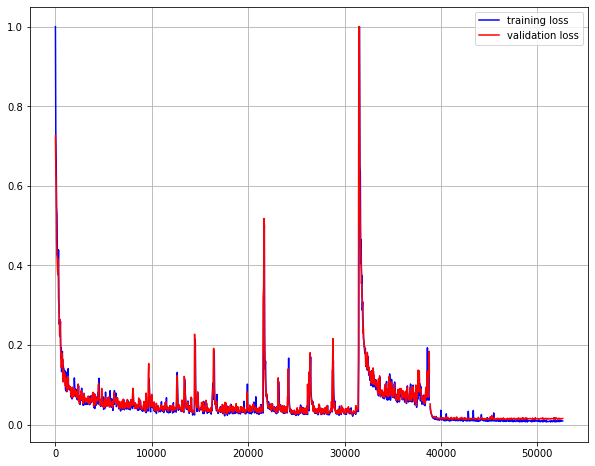

In [24]:
plt.figure(figsize=(10,8))
x1 = np.arange(0, len(tra01)-1, 40)
x2 = np.arange(0, (len(val01) -1)*40, 40)
plt.plot(x1 , tra01[1::40], color = 'b', label = 'training loss')
plt.plot(x2, val01[1:], color = 'r', label ='validation loss')
plt.grid()
plt.legend()
plt.show()

In [35]:
# cp_nn.train(training_parameters=training_params,
#                 training_features=features,
#                 filename_saved_model='/content/drive/MyDrive/21cm project/models/21cm_PS_NN_z=10.4_110922',
#                 # cooling schedule
#                 validation_split=0.1,
#                 learning_rates=[1e-2, 1e-3, 1e-4, 1e-5,1e-6],
#                 batch_sizes=[512, 512, 512, 512, 512],
#                 gradient_accumulation_steps = [1, 1, 1, 1, 1],
#                 # early stopping set up
#                 patience_values = [300,300,300,300,300],
#                 max_epochs = [2000,2000,2000,2000,2000],
#                 )

**testing**



---



---



In [8]:
cp_nn = cosmopower_NN(restore=True, 
                      restore_filename='/content/drive/MyDrive/21cm project/models/21cm_PS_NN_z=7.9_131022_all_params',
                      )

In [ ]:
predicted_testing_spectra = cp_nn.ten_to_predictions_np(testing_params)


In [ ]:
print(len(testing_params['F_STAR10']))

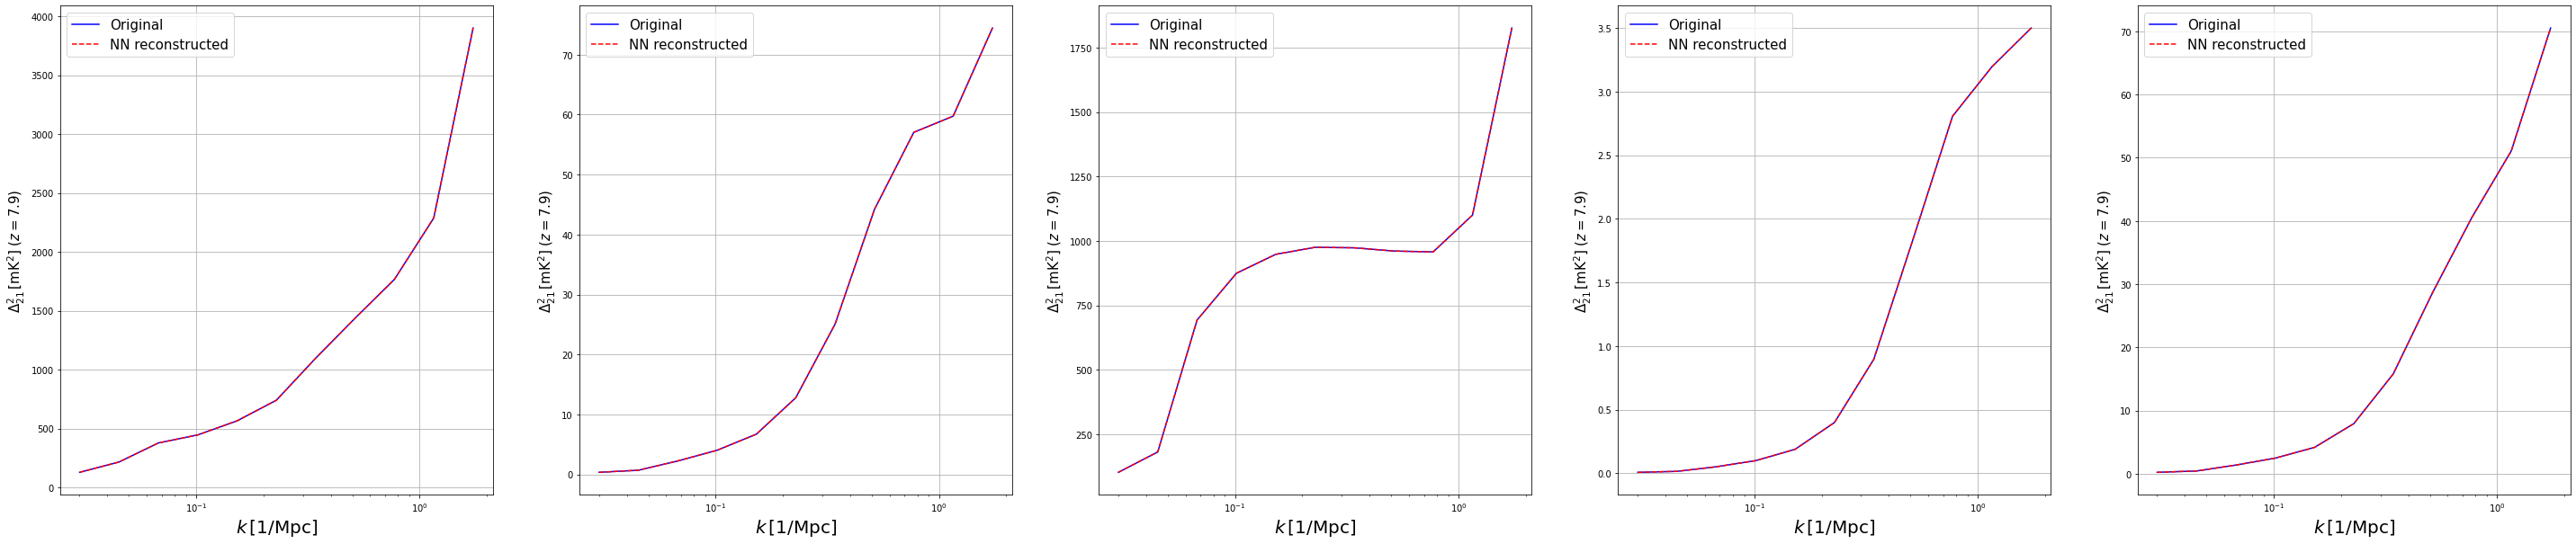

In [ ]:
from matplotlib import gridspec
import random
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(50,10))
for i in range(5):
    n = random.randint(0,len(testing_params['F_STAR10'])-1)
    pred = predicted_testing_spectra[n]
    
    true = testing_features[n]
    ax[i].semilogx(k_range, true, 'blue', label = 'Original')
    ax[i].semilogx(k_range, pred, 'red', label = 'NN reconstructed', linestyle='--')
    ax[i].set_xlabel('$k\,[1/\mathrm{Mpc}]$',fontsize=20)
    ax[i].set_ylabel('$\Delta_{21}^2\,[\mathrm{mK}^2]\,\,(z=$'+str(7.9)+')',fontsize=15)
    ax[i].legend(fontsize=15)
    ax[i].grid()
#plt.savefig('examples_reconstruction_TT.pdf')

worst params:  [-6.9147334e-02  9.0934646e-01 -2.2254553e+00  4.4677070e-01
  1.0454992e+01  5.1841235e-01  3.5096893e+01  1.5547832e+02
  2.6099513e+00]
max ps:  [   52.051037   125.05686    498.74283    928.29236   1765.3313
  2669.8596    3365.4905    3858.0403    4540.2754    6428.8135
 12174.851   ]
max pred:  [  56.15753834  175.18492925  337.58861494  476.44012782  762.47693233
 1080.00675185 1503.16283525 1833.73537095 2256.44395866 3109.54934873
 5563.88034411]
2545.413385826954
median: 0.02460403376475648


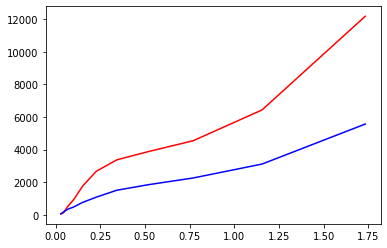

In [ ]:
dist = []
max = 0
max_index = None
for j in range(len(predicted_testing_spectra)):
  dist+=[np.sqrt(sum((1/11)*(predicted_testing_spectra[j]-testing_features[j])**2))]
  if dist[-1] > max:
    max_index = j
    max = dist[-1]
print('worst params: ', test_params_np[max_index])
print('max ps: ', testing_features[max_index])
print('max pred: ', predicted_testing_spectra[max_index])
print(max)
print('median:', np.median(dist))
# x = (testing_features[j] - predicted_testing_spectra[j])**2
# print(sum(x)/11)
# print(len(predicted_testing_spectra[0]))
plt.plot(k_range , testing_features[max_index] , c = 'r')
plt.plot(k_range , predicted_testing_spectra[max_index] , c = 'b')

In [ ]:
test_params_np = np.float32(cp_nn.dict_to_ordered_arr_np(testing_params))
testing_features = np.float32(testing_features)
loss = cp_nn.compute_loss(test_params_np, testing_features)
print(loss.numpy())

1876.2869


In [ ]:
print(test_params_np.shape)
filter = test_params_np[:,6] > 38
print(filter.shape)
filter_params = test_params_np[filter]
print(filter_params.shape)
testing_features_filter = testing_features[filter]
print(testing_features_filter.shape)

(2474, 9)
(2474,)
(803, 9)
(803, 11)


In [ ]:
loss_f = cp_nn.compute_loss(filter_params, testing_features_filter)
print(loss_f.numpy())
f_predicted_spectra = predicted_testing_spectra[filter]
print(f_predicted_spectra.shape)

649.04504
(803, 11)


worst params:  [-1.0633160e+00  7.1149802e-01 -3.6585718e-01 -3.6698157e-01
  1.0005779e+01  5.1644808e-01  3.8786839e+01  8.3294934e+02
  1.8468735e+00]
max ps:  [ 659.965  2047.5752 1960.6581 2098.07   1667.1453 1460.6036 1166.472
  932.9875  824.9237  924.8053 1626.2898]
max pred:  [155.04429299 273.54694909 375.22295096 460.09638474 429.04952476
 377.22335751 276.6627058  212.68086158 174.13250965 191.44389585
 337.38617646]
worst loss:  1176.9954181770456
median: 0.0011740368519969726
mean:  6.233609520140099
(803,)


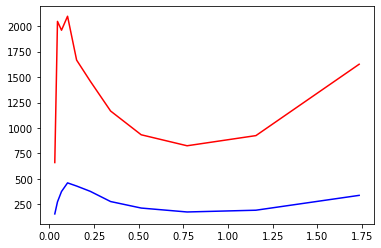

In [ ]:
dist = []
max = 0
max_index = None
for j in range(len(f_predicted_spectra)):
  dist+=[np.sqrt(sum((1/11)*(f_predicted_spectra[j]-testing_features_filter[j])**2))]
  if dist[-1] > max:
    max_index = j
    max = dist[-1]
print('worst params: ', filter_params[max_index])
print('max ps: ', testing_features_filter[max_index])
print('max pred: ', f_predicted_spectra[max_index])
print('worst loss: ',max)
print('median:', np.median(dist))
print('mean: ', np.mean(dist))
# x = (testing_features[j] - predicted_testing_spectra[j])**2
# print(sum(x)/11)
# print(len(predicted_testing_spectra[0]))
print(np.array(dist).shape)
plt.plot(k_range , testing_features_filter[max_index] , c = 'r')
plt.plot(k_range , f_predicted_spectra[max_index] , c = 'b')

In [ ]:

k_err = np.zeros(len(predicted_testing_spectra[0]))
for j in range(len(predicted_testing_spectra)):
  for i in range(len(k_err)):
    k_err[i]+= np.abs((predicted_testing_spectra[j][i]-testing_features[j][i])/testing_features[j][i])

print(k_err/len(predicted_testing_spectra))

[0.01065946 0.0099915  0.00956342 0.00977063 0.00925521 0.00884403
 0.0090648  0.00964818 0.01026211 0.01108935 0.01151639]


In [ ]:
k_e = [[] for i in range(len(predicted_testing_spectra[0]))]
print(k_e)
for j in range(len(predicted_testing_spectra)):
  for i in range(len(k_err)):
    k_e[i]+= [np.abs((predicted_testing_spectra[j][i]-testing_features[j][i])/testing_features[j][i])]
print(np.argmax(k_e,axis = 1))
k_e = np.array(k_e)
print(k_e[:,1558])
print(predicted_testing_spectra[1558])
print(testing_features[1558])
print(test_params_np[1558])

In [ ]:
# emulator_k_modes = [0.0307812, 0.04617179, 0.06925769, 0.10388654, 0.1558298, 0.23374471,
#                     0.35061706, 0.52592559, 0.78888838, 1.18333258, 1.77499887]
# params = {'F_STAR10': [-0.45,-0.45], 'F_ESC10': [-0.33,-0.33], 'L_X':[40,42] , 'M_TURN': [9.35,9.35], 'NU_X_THRESH': [400, 1200]}

# #print(params)
# testing = cp_nn.ten_to_predictions_np(params)
# plt.semilogx(emulator_k_modes , testing[0], color = 'r')
# plt.semilogx(emulator_k_modes, testing[1], color = 'b', ls='--')
# plt.show()